<a href="https://colab.research.google.com/github/agron-gojcaj/IntrusionDetection/blob/main/Model_Comparisons_for_Intrusion_Detection_NSLKDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [34]:
# === STEP 1: Load Data ===
train_df = pd.read_csv('kdd_train.csv')
test_df = pd.read_csv('kdd_test.csv')

In [35]:
# === STEP 2: Encode Categorical Columns ===
categorical_cols = ['protocol_type', 'service', 'flag']
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

In [36]:
# === STEP 3: Binary Labels ===
train_df['labels'] = train_df['labels'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['labels'] = test_df['labels'].apply(lambda x: 0 if x == 'normal' else 1)

In [37]:
# === STEP 4: Feature/Label Split ===
X_train = train_df.drop('labels', axis=1).values.astype(np.float32)
y_train = train_df['labels'].values.astype(np.int32)
X_test = test_df.drop('labels', axis=1).values.astype(np.float32)
y_test = test_df['labels'].values.astype(np.int32)

In [38]:
# === STEP 5: Normalize ===
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# === STEP 6: PyTorch Tensors for NN ===
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).float()
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1).float()

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# === STEP 7: Deep Learning Model (SimpleNN) ===
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_nn(epochs=20):
    model = ImprovedNN(X_train.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)

        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_pred_binary = (y_pred > 0.5).astype(int)
    return y_pred_binary.flatten()

In [41]:
# === STEP 8: ML Models (Random Forest, SVM) ===
def train_rf():
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

def train_svm():
    clf = SVC(kernel='rbf', gamma='scale')
    clf.fit(X_train[:5000], y_train[:5000])  # SVM is slow on large datasets
    return clf.predict(X_test[:5000]), y_test[:5000]  # Match prediction slice

In [42]:
# === STEP 9: Evaluation Function ===
def get_metrics(y_true, y_pred, name):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }

In [43]:
# === STEP 10: Run All Models & Compare ===
results = []

# Deep Learning
y_pred_nn = train_nn()
results.append(get_metrics(y_test, y_pred_nn, "NN"))

# Random Forest
y_pred_rf = train_rf()
results.append(get_metrics(y_test, y_pred_rf, "Random Forest"))

# SVM (on subset)
y_pred_svm, y_test_svm = train_svm()
results.append(get_metrics(y_test_svm, y_pred_svm, "SVM (subset)"))

Epoch [1/20] - Loss: 0.0894
Epoch [6/20] - Loss: 0.0262
Epoch [11/20] - Loss: 0.0226
Epoch [16/20] - Loss: 0.0206
Epoch [20/20] - Loss: 0.0186


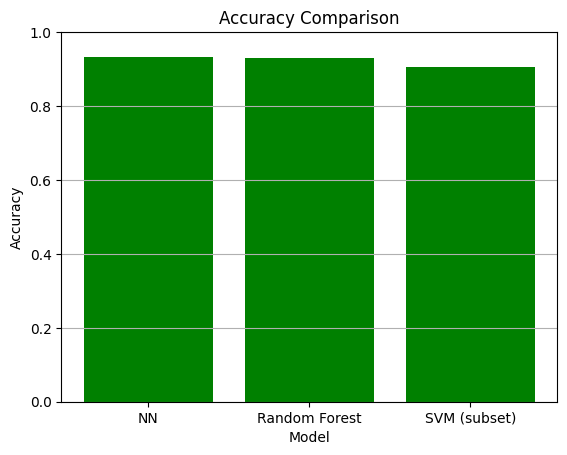

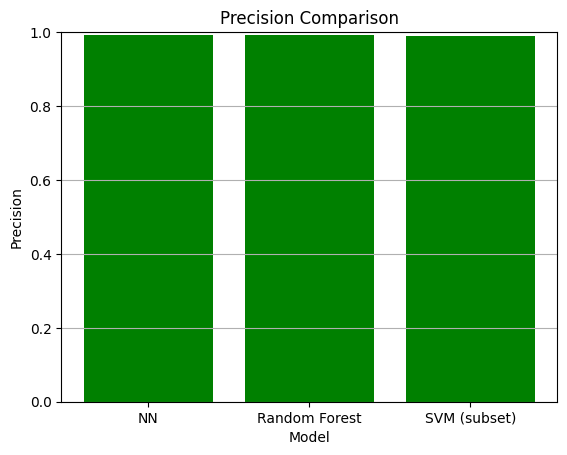

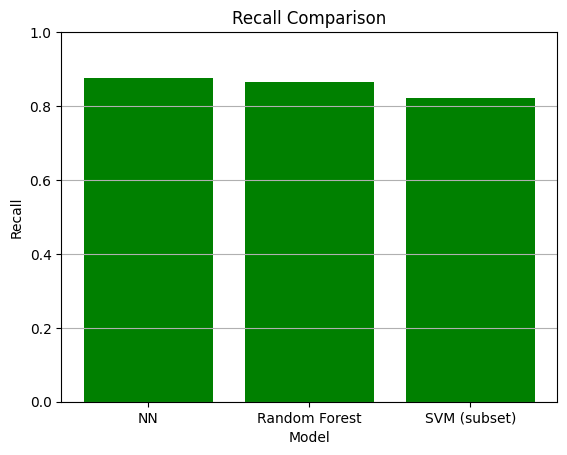

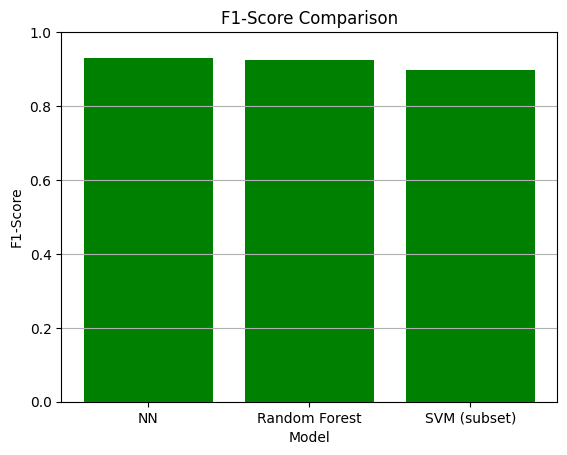

           Model  Accuracy  Precision    Recall  F1-Score
0             NN  0.933774   0.990987  0.875830  0.929857
1  Random Forest  0.929072   0.991090  0.866271  0.924486
2   SVM (subset)  0.904400   0.989637  0.821666  0.897863


In [44]:
# === STEP 11: Plot Results ===
df_results = pd.DataFrame(results)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

for metric in metrics:
    plt.figure()
    plt.bar(df_results["Model"], df_results[metric], color='green')
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xlabel("Model")
    plt.grid(axis='y')
    plt.show()

# View improved scores
print(df_results)